In [38]:
'''
In this notebook we carry out the adaptive variant of the 
Variational quantum deflation algorithm 
for random 2 site Fermionic Hamiltonians
'''
'''
Author-Anirban Mukherjee
Dated-10/13/2021

'''

'\nAuthor-Anirban Mukherjee\nDated-10/13/2021\n\n'

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy
import copy
import qiskit
from qiskit.circuit.random import random_circuit
from qiskit.opflow.primitive_ops import PauliSumOp
import ipyparallel as ipp
from qiskit.aqua.operators.legacy import op_converter
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit.quantum_info import Pauli
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from joblib import Parallel,delayed
from qiskit.aqua.operators import WeightedPauliOperator,Z2Symmetries
from qiskit.chemistry.components.variational_forms import UCCSD
import scipy
import time

In [6]:
#Construct Model Hamiltonian
def count_gates(pauli_label):
    countYgates = sum(map(lambda x : 1 if 'Y' in x else 0, pauli_label))
    countXgates = sum(map(lambda x : 1 if 'X' in x else 0, pauli_label))
    countZgates = sum(map(lambda x : 1 if 'Z' in x else 0, pauli_label))
    return countYgates+countXgates+countZgates
def qubitOp(h1,h2):
    num_qubits=h1.shape[0]
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    mapper=ParityMapper()
    qubit_op=mapper.map(fer_op)
    qubit_conv = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = qubit_conv.convert(fer_op, num_qubits//2)
    return qubit_op
def Hamiltonian(h1=None,h2=None):
    if numpy.any(h1)==None:
        h1=2*numpy.random.rand(num_qubits,num_qubits)-1
        #impose hermiticity on h1
        h1=(h1+h1.T)/2.
    if numpy.any(h2)==None:    
        h2=numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))#numpy.random.rand(num_qubits,num_qubits,num_qubits,num_qubits)
    #impose eight-fold symmetry
        h2=(1/8.)*(h2+numpy.transpose(h2,(3,2,1,0))+numpy.transpose(h2,(0,1,3,2))+numpy.transpose(h2,(1,0,2,3))
                      +numpy.transpose(h2,(1,0,3,2))+numpy.transpose(h2,(2,3,1,0))+numpy.transpose(h2,(2,3,0,1))
                      +numpy.transpose(h2,(3,2,0,1)))
    
    qubitH=qubitOp(h1,h2)
    Hmat=qubitH.to_matrix(massive=True)
    w,v=numpy.linalg.eigh(Hmat)
    Eg=w[0]
    Ee=w[1]
    state_g=v[:,0]
    state_e=v[:,1]
    return qubitH,Hmat,Eg,Ee,state_g,state_e,h1,h2

In [7]:
def commutator(A,B):
        B2=WeightedPauliOperator([[-B.paulis[0][0],B.paulis[0][1]]])
        return A.multiply(B).add(B2.multiply(A))
def commutatorsForGradient(Op):
    Op_conj=WeightedPauliOperator([[-1j,Op.paulis[0][1]]])
    M=Op.multiply(weighted_H).add(weighted_H.multiply(Op_conj))
    Mmat=op_converter.to_matrix_operator(M).matrix
    return Mmat
def Pool():
    unique_labels=['II', 'IX', 'IY', 'XI', 'XX', 'XY', 'YI', 'YX', 'YY']
    pool=[WeightedPauliOperator([[1j,Pauli(unique_labels[i])]]) for i in range(len(unique_labels))]
    print(len(pool))
    return pool
def compute_gradient(Op,state):
    Op_mat=op_converter.to_matrix_operator(Op).dense_matrix
    grad=numpy.abs(state_g@Op_mat@numpy.conjugate(state))**2
    return grad


## Standard Cost Fn. for VQE
$E=\langle\Psi|H|\Psi\rangle$ (cost Fn.)

In [8]:
def cost_fn(params,ansatz,save_steps):
    circ=ansatz.construct_circuit(parameters=params)
    state=execute(circ,backend,shots=1024).result().get_statevector() 
    E=(numpy.conjugate(state)@Hmat@state).real
    if save_steps==True:
        with open('data_test.txt','+a') as f:
            Str=["{:0.16f}".format(params[i].real) for i in range(len(params))]
            print('['+','.join(Str)+']'+'#'+"{:0.16f}".format(E.real),file=f)
    return E

npj Computational Materials (2021) 7:70 ; https://doi.org/10.1038/s41524-021-00540-

## Cost function for Variational quantum deflation
$E=\langle\Psi|H|\Psi\rangle+\beta_{0}|\langle\Psi_{gs-ansatz}|\Psi\rangle|^{2}$

#### $|\Psi_{gs-ansatz}\rangle$ is the circuit ansatz we generate using adapt VQE

In [9]:
def cost_fn_exc(params,ansatz,save_steps):
    circ=ansatz.construct_circuit(parameters=params)
    state=execute(circ,backend,shots=1024).result().get_statevector() 
    beta0=1e2
    E=(numpy.conjugate(state)@Hmat@state).real+beta0*numpy.abs(state.conj()@gs_ansatz)**2
    if save_steps==True:
        with open('data_test.txt','+a') as f:
            Str=["{:0.16f}".format(params[i].real) for i in range(len(params))]
            print('['+','.join(Str)+']'+'#'+"{:0.16f}".format(E.real),file=f)
    return E

In [10]:
num_qubits=4
#h1 is a random 4x4 hopping Hamiltonian
qubitH,Hmat,Eg,E1,state_g,state_e,h1,h2=Hamiltonian(h1=numpy.array([[-0.15330462,  0.02091958,  0.17718115,  0.13541518],
 [ 0.02091958,  0.79703582,  0.57483787, -0.62102366],
 [ 0.17718115,  0.57483787,  0.93545435,  0.50209789],
 [ 0.13541518, -0.62102366,  0.50209789, -0.2842575 ]]))

In [11]:
#Hamiltonian is a Tapered Summed Pauli Operator oobtained from parity encoding and two qubit reduction
print(qubitH)

(0.36004508999999996+2.7755575615628914e-17j) * II
+ 0.6098559249999997 * ZI
+ (0.47517022+2.7755575615628914e-17j) * IZ
+ (0.2874189349999999+2.7755575615628914e-17j) * ZZ
+ 0.5020978899999998 * XI
+ 0.3105118299999999 * YI
- 0.3105118299999999 * XZ
+ 0.020919579999999993 * IX
+ (0.08859057499999996+6.938893903907228e-18j) * ZX
- 0.08859057499999996 * IY
+ 0.06770758999999997 * XX
+ (0.06770758999999997-6.938893903907228e-18j) * YY


In [12]:
#function added for convenience to map onto weighted pauli operator of qiskit aqua package
def _to_weighted_pauli_operator(Op):
    weighted_op=WeightedPauliOperator([[0,Pauli('I'*(num_qubits-2))]])
    for i in range(len(Op)):
        List=Op[i:i+1].primitive.to_list()
        weighted_op.add(WeightedPauliOperator([[List[0][1],Pauli(List[0][0])]]))
    return weighted_op                   

In [13]:
weighted_H=_to_weighted_pauli_operator(qubitH)

In [14]:
#Hamiltonian commutator pool
pool=Pool()
backend=Aer.get_backend('statevector_simulator')
#preparing HF state
circ=QuantumCircuit(2)
circ.x(0)
#initializing ansatz ref state as |10>
var_form_base=UCCSD(4,num_particles=2, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
var_form_base.manage_hopping_operators()
error=1000

9
pool sizes 8


# the function below carries out adapt VQE with a given cost fn.

In [15]:
def adapt_vqe(cost_fn,commutator_pool,var_form_base_2):
    params=[]
    EnergyArr=[]
    ExcOps=[]
    ti=time.time()
    steps=15
    for i in range(15):
        save_steps=False
        circ=var_form_base_2.construct_circuit(parameters=params)
        state=execute(circ,backend,shots=1024).result().get_statevector()
        grads=numpy.array(Parallel(n_jobs=1,verbose=2)(delayed(compute_gradient)(pool[i],state) for i in range(len(pool[1:]))))#qubit_pool_UCCSD))))#
        indexes=numpy.argsort(abs(grads))[::-1][:3]
        print("three highest grads",grads[indexes[0]],grads[indexes[1]],grads[indexes[2]])
        if ((i>=1) and (pool[1:][indexes[0]].paulis[0][1].to_label()==ExcOps[-1])):
            chosen_id=indexes[1]
        elif ((i>=2) and (pool[1:][indexes[0]].paulis[0][1].to_label()==ExcOps[-2])):
            chosen_id=indexes[2]
        else:
            chosen_id=indexes[0]
        PauliOp=pool[1:][chosen_id]
        ExcOps.append(PauliOp.paulis[0][1].to_label())
        print("chosen Op",ExcOps[-1])
        with open('data_test.txt','a') as f:
            print("label-",ExcOps[-1],file=f)
        params.append(0.0)
        var_form_base_2.push_hopping_operator(PauliOp)
        #construct circuit for estimating Hamiltonian
        #res=SMO(cost_fn,params,runs=10,tol=1e-6,save_opt_steps=True)
        #E,params=res['fun'],list(res['x'])
        res=scipy.optimize.minimize(cost_fn_exc,params,args=(var_form_base_2,True),method='BFGS',options={'ftol':1e-7})
        params,E=list(res['x']),res['fun']
        print("num_params",var_form_base.num_parameters)
        print("Energy",E)
        EnergyArr.append(E)
        print("time elapsed",time.time()-ti)    
        error=EnergyArr[-1]-Eg

In [16]:
#This qubit-adapt VQE functionality leads to the ground state below

#adapt_vqe(cost_fn,commutator_pool,var_form_base)

In [17]:
#
lines=[]
with open('data_test.txt','r') as f:
    lines=f.readlines()
    Labels=[]
    for i in range(len(lines)):
        if (lines[i][0]=='l'):
            Label=lines[i].split('-')[1][1:-1]
            Labels.append(Label)
        if (lines[i][0]=='E'):
            params=eval(lines[i-1])
            break

In [18]:
def build_parametrized_ansatz(init_circ,generators):
    var_form_base=UCCSD(4,num_particles=2, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
    var_form_base.manage_hopping_operators()
    for i in range(len(generators)):
        var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(generators[i])]]))
    return var_form_base    

In [19]:
#build parametrized circuit for gs from the data_file
circ=QuantumCircuit(2)
circ.x(0)
var_form_base=build_parametrized_ansatz(circ,Labels)
circ=var_form_base.construct_circuit(parameters=params)
gs_ansatz=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()

In [20]:
save_steps=False
print("gs energy from ansatz",cost_fn(params,var_form_base,save_steps)),print("ground state energy from exact diagonalization",Eg)

gs energy from ansatz -1.0742140617591374
ground state energy from exact diagonalization -1.0742140617755906


(None, None)

## Construct new ansatz for excited state using adaptive variational quantum deflation

In [179]:
exc_var_form_base=UCCSD(4,num_particles=2, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
exc_var_form_base.manage_hopping_operators()

In [37]:
#implemeting VQD in the adaptive route
adapt_vqe(cost_fn_exc,commutator_pool,exc_var_form_base)

In [21]:
#
lines=[]
with open('data_test.txt','r') as f:
    lines=f.readlines()
    Labels=[]
    numCXarr=[]
    numCX=0
    Energy_gs_arr=[]
    for i in range(len(lines)):
        if (lines[i][0]=='l'):
            Label=lines[i].split('-')[1][1:-1]
            Labels.append(Label)
            numCX=numCX+(2*count_gates(Labels[-1])-1)
            numCXarr.append(numCX)
            Energy_gs_arr.append(eval(lines[i+1].split('#')[1]))
        if (lines[i][0]=='E'):
            Energy_gs_arr.append(eval(lines[i-1].split('#')[1]))
            params=eval(lines[i-1])
            break

In [22]:
Energy_gs_arr,numCXarr

([-0.118364709081987,
  -0.1183647090819871,
  -0.1537275387087862,
  -0.5672657535381151,
  -0.6021422095724944,
  -1.0142107581272306,
  -1.0719461702480686,
  -1.074214052233935],
 [3, 4, 5, 6, 9, 10, 11])

In [206]:

#initializing ansatz ref state as |10>
exc_var_form_base=UCCSD(4,num_particles=2, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
exc_var_form_base.manage_hopping_operators()
exc_var_form_base=build_parametrized_ansatz(circ,Labels)

In [207]:
exc_var_form_base.num_parameters

7

In [213]:
#build parametrized circuit for excited state from the data_file
exc_var_form_base=build_parametrized_ansatz(circ,Labels)
exc_circ=exc_var_form_base.construct_circuit(parameters=params)
exc_ansatz=execute(exc_circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()

In [12]:
# save_steps=False
# print("exc energy from ansatz",cost_fn(params,exc_var_form_base,save_steps)),print("exc state energy from exact diagonalization",Eg)

In [26]:
lines=[]
with open('data_test.txt','r') as f:
    lines=f.readlines()
    Labels=[]
    numCXarr1=[]
    numCX=numCXarr[-1]
    flag=0
    Energy_exc_arr=[]
    for i in range(len(lines)):
        if ((lines[i][0]=='E') or (flag==1)):
            flag=1
            if lines[i][0]=='l':
                Label=lines[i].split('-')[1][1:-1]
                Labels.append(Label)
                numCX=numCX+(2*count_gates(Labels[-1])-1)
                numCXarr1.append(numCX)
                
                params=eval(lines[i+1])
                Energy_exc_arr.append(eval(lines[i+1].split('#')[1][:-1]))
    Energy_exc_arr.append(eval(lines[-1].split('#')[1][:-1]))      

In [27]:
Energy_exc_arr,numCXarr1

([98.92578593824084,
  98.92578593824084,
  98.92578593824084,
  98.92578593824082,
  98.92578593824084,
  98.92578593824084,
  98.92578593824082,
  98.92578593824082,
  0.4872839253391934,
  0.157075888967542,
  -0.1076732179012416],
 [12, 15, 18, 19, 22, 25, 26, 29, 32, 33])

In [28]:
save_steps=False
print("exc energy from ansatz",Energy_exc_arr[-1]),print("exc state energy from exact diagonalization",E1)

exc energy from ansatz -0.1076732179012416
exc state energy from exact diagonalization -0.10767321790239351


(None, None)

In [28]:
import matplotlib.pyplot as plt

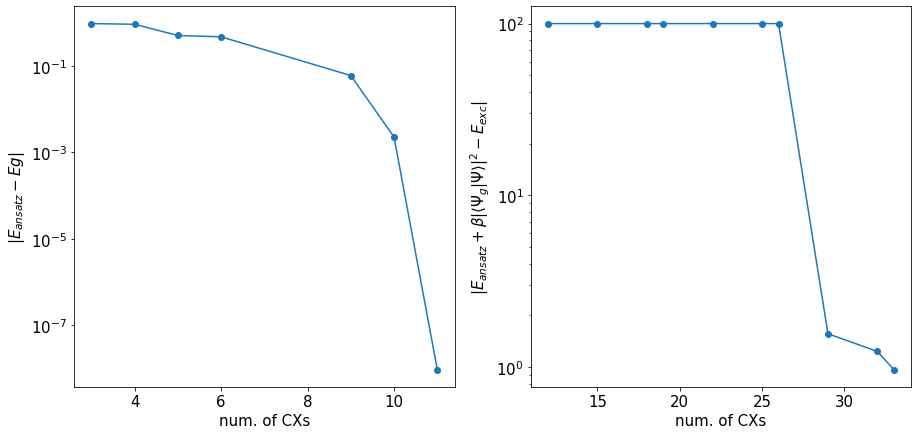

In [45]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
ax[0].set_xlabel("num. of CXs",fontsize=15)
ax[0].set_ylabel(r'$|E_{ansatz}-Eg|$',fontsize=15)
ax[0].plot(numCXarr,Energy_gs_arr[1:]-Eg,marker='o')
ax[0].tick_params(labelsize=15)
ax[0].set_yscale('log')
ax[1].set_xlabel("num. of CXs",fontsize=15)
ax[1].set_ylabel(r'$|E_{ansatz}+\beta |\langle \Psi_{g}|\Psi\rangle|^{2}-E_{exc}|$',fontsize=15)
ax[1].plot(numCXarr1,Energy_exc_arr[1:]-Eg,marker='o')
ax[1].tick_params(labelsize=15)
ax[1].set_yscale('log')

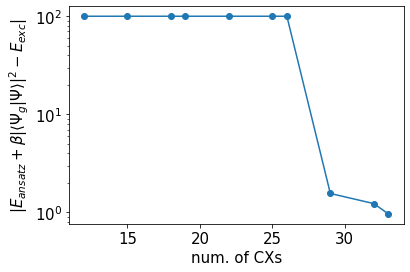

In [36]:
fig,ax=plt.subplots(1,1)
ax.set_xlabel("num. of CXs",fontsize=15)
ax.set_ylabel(r'$|E_{ansatz}+\beta |\langle \Psi_{g}|\Psi\rangle|^{2}-E_{exc}|$',fontsize=15)
ax.plot(numCXarr1,Energy_exc_arr[1:]-Eg,marker='o')
ax.tick_params(labelsize=15)
ax.set_yscale('log')